In [1]:
# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import skimage
from skimage import io, transform
import numpy as np
from matplotlib import pyplot as plt

print(tf.__version__)

2.5.0


# VGG 16

we will be analyzing Visual Geometry Group's (VGG) 16 layer convolutional neural network. The network was trained on ImageNet, a dataset of over 14 million images with 1000 different classes. It has over 100 million parameters. Luckily, Keras has the weights built in, so we can simply load the model as well as its weights like so:

![alt text](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png))

In [2]:
model = tf.keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

553467904/553467096 [==============================] - 4s 0us/step


What exactly is going on inside this network? A valuable way to debug/analyze a network is to look at intermediate layers' outputs. Fortunately, Keras makes it easy with some nice functionality provided by its `Model` class. 

In [3]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Mounted at /content/gdrive


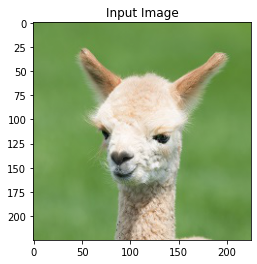

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
llama = skimage.img_as_float(skimage.io.imread('https://drive.google.com/uc?export=view&id=1cLnfOjNLKswQLsDJdOXFuzang6nYuL89'))

plt.imshow(llama)
plt.title('Input Image')
plt.show()

Note that the background contrasts sharply with the llama, and that the llama has prominent features such as eyes, a nose, and a mouth. This makes this picture a good candidate to see what our network can detect.

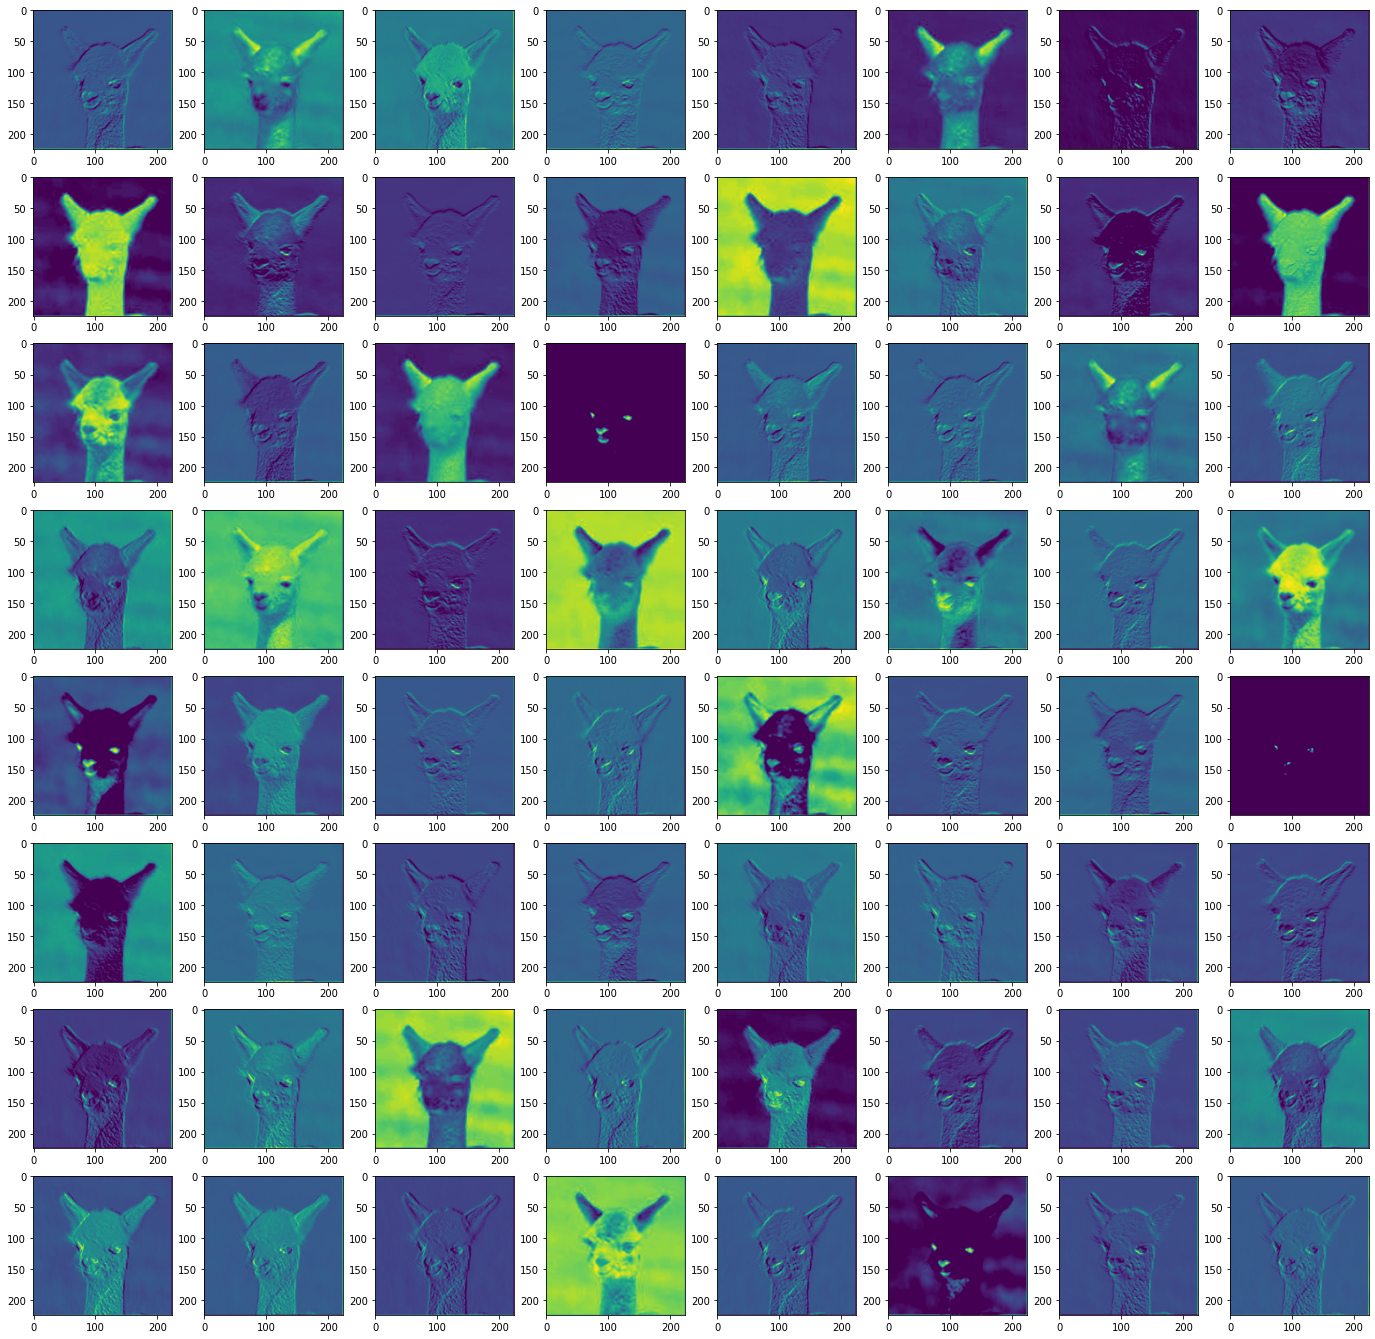

In [8]:
image = skimage.transform.resize(llama, [224,224,3])

# Try out different layers
#  - block1_conv1
#  - block3_pool
#  - block5_pool

layer_name = "block1_conv1"
intermediate_layer_model = tf.keras.Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(image[None,:,:,:])

fig, axes = plt.subplots(8,8, figsize=(24,24))
for i in range(64):
  axes[int(i/8),i%8].imshow(intermediate_output[0,:,:,i])
plt.show()

Now let us find another image from the internet, and run it through the network and plot the intermediate outputs as you did before.

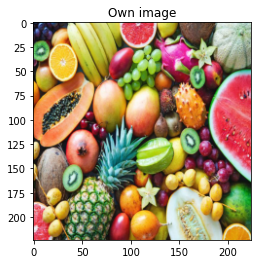

In [12]:
plt.imshow(image)
plt.title('Own image')
plt.show()

In [13]:
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)
image = skimage.img_as_float(skimage.io.imread('https://post.medicalnewstoday.com/wp-content/uploads/sites/3/2020/02/325253_2200-732x549.jpg'))

# Resizing image to (224,224,3) so it matches the input size of VGG16
image = skimage.transform.resize(image, [224,224,3])

# Filling in layer name 
layer_name = 'block1_conv1' 
#layer_name = "block3_pool"
#layer_name = "block5_pool"
intermediate_layer_model = tf.keras.Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(image[None,:,:,:])

fig, axes = plt.subplots(8,8, figsize=(24,24))
for i in range(64):
  axes[int(i/8),i%8].imshow(intermediate_output[0,:,:,i])
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Our own CNN

In [29]:
class Model(tf.keras.Model):

  def __init__(self,):
    """
    The model class inherits from tf.keras.Model.
    It stores the trainable weights as attributes.
    """
    super(Model, self).__init__()
    
    # Initializing variables (weights) here:
    # Remember that the input size is 784 and the output size (number of classes) is 10 
    self.filter1 = tf.Variable(tf.random.normal([3, 3, 1, 32], stddev=.1))
    self.filter2 = tf.Variable(tf.random.normal([3, 3, 32, 64], stddev=.1))
    self.filter3 = tf.Variable(tf.random.normal([3, 3, 64, 64], stddev=.1))
    self.W1 = tf.Variable(tf.random.normal([4*4*64, 10], stddev=.1))
    self.b1 = tf.Variable(tf.random.normal([10], stddev=.1))

  def call(self, inputs):
    """
    Forward pass, predicts labels given an input image using fully connected layers
    :return: the probabilites of each label
    """

    layer1Output = tf.nn.convolution(inputs, self.filter1, strides=1, padding='SAME')
    layer1Output = tf.nn.max_pool(layer1Output, 2, 2, padding='SAME')
    logits1 = tf.nn.relu(layer1Output)

    layer2Output = tf.nn.convolution(logits1, self.filter2, strides=1, padding='SAME')
    layer2Output = tf.nn.max_pool(layer2Output, 2, 2, padding='SAME')
    logits2 = tf.nn.relu(layer2Output)
    
    layer3Output = tf.nn.convolution(logits2, self.filter3, strides=1, padding='SAME')
    layer3Output = tf.nn.max_pool(layer3Output, 2, 2, padding='SAME')
    logits3 = tf.nn.relu(layer3Output)
    
    layer3Output = tf.reshape(logits3, [layer3Output.shape[0], -1])
    
    layer4Output = tf.matmul(layer3Output, self.W1) + self.b1
  
    prbs = tf.nn.softmax(layer4Output)
    
    return prbs
  
  def loss(self, predictions, labels):
    """
    Calculates the model loss
    :return: the loss of the model as a tensor
    """
    return tf.keras.losses.binary_crossentropy(labels, predictions)

  
  def accuracy(self, predictions, labels):
    """
    Calculates the model accuracy
    :return: the accuracy of the model as a tensor
    """
    return tf.reduce_mean(tf.keras.metrics.categorical_accuracy(labels, predictions))




In [42]:
# Loading in and preprocessing the data
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.astype(np.float32)

# Making our labels one hot vectors
y_train = tf.one_hot(y_train, 10, dtype=tf.float32)
y_test = tf.one_hot(y_test, 10, dtype=tf.float32)

# Instantiate our model
model = Model()

# Choosing our optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)


In [ ]:
# Loop through 5000 training images for 3 epochs
BATCH_SZ = 128
num_epochs = 3
for j in range(num_epochs):
  print('Epoch: ', j+1)
  for i in range(0, 5000, BATCH_SZ):
    image = x_train[i:i + BATCH_SZ, :, :, np.newaxis]
    label = y_train[i:i + BATCH_SZ]
    # Implement backprop:
    with tf.GradientTape() as tape:
      predictions = model(image) # this calls the call function conveniently
      loss = model.loss(predictions, label)

      if i//BATCH_SZ % 4 == 0:
        train_acc = model.accuracy(model(image), label)
        print("Accuracy on training set after {} training steps: {}".format(i, train_acc))

    
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Epoch:  1
Accuracy on training set after 0 training steps: 0.09375
Accuracy on training set after 512 training steps: 0.265625
Accuracy on training set after 1024 training steps: 0.5078125
Accuracy on training set after 1536 training steps: 0.7890625
Accuracy on training set after 2048 training steps: 0.765625
Accuracy on training set after 2560 training steps: 0.7578125
Accuracy on training set after 3072 training steps: 0.8125
Accuracy on training set after 3584 training steps: 0.9140625
Accuracy on training set after 4096 training steps: 0.890625
Accuracy on training set after 4608 training steps: 0.8828125
Epoch:  2
Accuracy on training set after 0 training steps: 0.890625
Accuracy on training set after 512 training steps: 0.8671875
Accuracy on training set after 1024 training steps: 0.8515625
Accuracy on training set after 1536 training steps: 0.9375
Accuracy on training set after 2048 training steps: 0.9375
Accuracy on training set after 2560 training steps: 0.890625
Accuracy on 

In [28]:
# Loop through 5000 training images
Acc = 0
n = 0
for i in range(0, 5000, BATCH_SZ):
  image = x_test[i:i + BATCH_SZ, :, :, np.newaxis]
  label = y_test[i:i + BATCH_SZ]
  
  predictions = model(image) # this calls the call function conveniently
  loss = model.loss(predictions, label)
  
  train_acc = model.accuracy(model(x_test[i:i + BATCH_SZ, :, :, np.newaxis]), y_test[i:i + BATCH_SZ])
  n +=1
  Acc += train_acc
  
print('Test accuracy: {}'.format(Acc/n)) 

Test accuracy: 0.9482421875
